In [1]:
import pandas as pd
from Python_Scripts import generate_plots as plots
from Python_Scripts import order_analyses as analyses

ITEMS = ['I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23']

LEFT = ITEMS[:9]
CENTRE = ITEMS[3:12]
RIGHT = ITEMS[6:]

LOCS = [('L', LEFT),
        ('C', CENTRE), 
        ('R', RIGHT)]
ORDERS = [('f', 0, [1, 2, 3, 4, 5, 6, 7, 8]),
          ('m', 4, [0, 1, 2, 3, 5, 6, 7, 8]),
          ('b', 8, [0, 1, 2, 3, 4, 5, 6, 7])]

# Data not saved due to technical errors during collection
prolific1_tech = 1 
prolific2_tech = 3

In [2]:
allParticipants = pd.read_csv('Results/participant_data.csv')
allTrials = pd.read_csv('Results/trial_data.csv')

## Demographics

In [3]:
N = allParticipants.shape[0] + prolific1_tech + prolific2_tech
N_prolific1 = allParticipants[allParticipants['POOL'] == 'prolific1'].shape[0] + prolific1_tech 
N_prolific12 = allParticipants[allParticipants['POOL'] == 'prolific2'].shape[0] + prolific2_tech 
N_rep = allParticipants[allParticipants['POOL'] == 'rep'].shape[0]


badComprehension = allParticipants[allParticipants['ATTEMPTS'] > 2]['P_ID'].to_list()
tooManyErrors = allParticipants[(allParticipants['TOTAL_ERRORS'] > 3) & (allParticipants['ATTEMPTS'] <= 2)]['P_ID'].to_list()
both = len(set(badComprehension) & set(tooManyErrors))

sampleDF = allParticipants[(allParticipants['ATTEMPTS'] < 3) & (allParticipants['TOTAL_ERRORS'] < 4)]
participants = sampleDF['P_ID'].tolist()
trialDF = allTrials[allTrials['P_ID'].isin(participants)]

print(f'We collected data from {N} participants across 3 pool: REP (N = {N_rep}), Prolific 1 (N = {N_prolific1}), and Prolific 2 (N = {N_prolific12})\n')
print(f'{prolific1_tech+prolific2_tech} participant was excluded due to technical issues.')
print(f'{len(badComprehension)} participants were excluded for failing to answer 6 comprehension questions correctly after 3 attempts at answering them.')
print(f'{len(tooManyErrors)} participants were excluded for making more than 3 categorization errors.')

print(f'\nWe included N = {sampleDF.shape[0]} participants, {sampleDF['GENDER'].value_counts()['woman']} were women and {sampleDF['GENDER'].value_counts()['man']} were men.')
print(f'Ages ranged from {sampleDF['AGE'].min()} to {sampleDF['AGE'].max()} (median: {sampleDF['AGE'].median():.0f} years).')

We collected data from 419 participants across 3 pool: REP (N = 80), Prolific 1 (N = 159), and Prolific 2 (N = 180)

4 participant was excluded due to technical issues.
15 participants were excluded for failing to answer 6 comprehension questions correctly after 3 attempts at answering them.
14 participants were excluded for making more than 3 categorization errors.

We included N = 386 participants, 230 were women and 155 were men.
Ages ranged from 18 to 75 (median: 33 years).


## Main Results
For now we focus on the second level category assignment of items, regardless if participants added items to a hierarchy with 2 or 3 levels of categorization

In [4]:
cleanedTrial = analyses.get_level2_cat_stats(trialDF, ITEMS)
cleanedTrial.to_csv('Results/level2_trial_data.csv', index=None)

Results did not vary much by participant pool, so we combine analysis of the participant pools in the main results

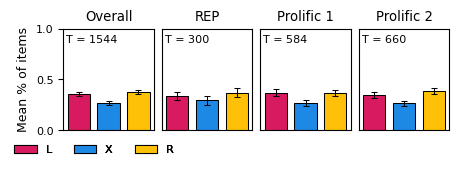

In [5]:
plots.generate_summary_LXR_plot(cleanedTrial, 'POOL', ['rep', 'prolific1', 'prolific2'], ['REP', 'Prolific 1', 'Prolific 2'], figsize=(4.4, 1.35), fname='Figures/LXR_by_pool.pdf', overall=True)

#### 1. The sequence of item presentation leads to different category assignments.
Specifically, the mean proportion of items assigned to categories A, B, and X differs with each item presentation order.  We look at this individually for each location as well as overall. 

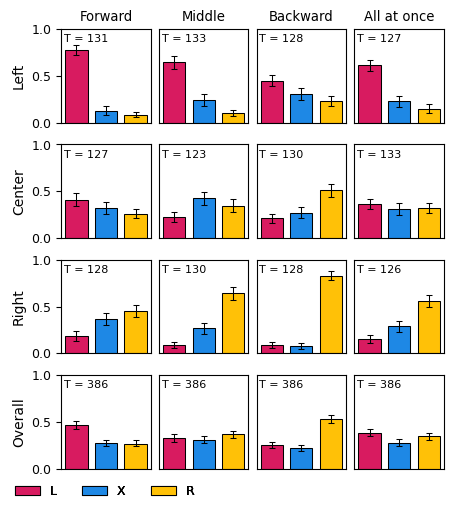

In [6]:
plots.order_effects_plot(cleanedTrial, figsize=(4.4, 4.75), legend=True, fname='Figures/Powerpoint.pdf')

#### 2. When presented in sequence, items are more likely than not to be assigned to the same category as the first item categorized.
This is partially because all new items shown are meant to be similar to one another. We compute the median, mean, and mode proportion of items assigned to the same category as the first in a sequence.

42.23
Mean: 0.727
Median items: 0.875
Mode: 1.0


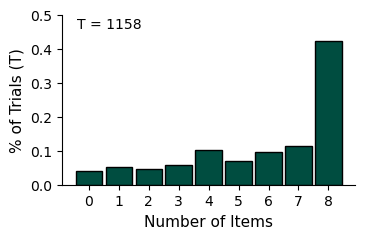

In [7]:
seq_df, long_df = analyses.get_seq_data(cleanedTrial, LOCS, ORDERS)
seq_df.to_csv('Results/hyp2_df.csv', index=None)
long_df.to_csv('Results/hyp2_df_long.csv', index=None)

mean_prob = seq_df['PROP_SAME'].mean()
median_prob = seq_df['PROP_SAME'].median()
mode_probs = seq_df['PROP_SAME'].mode().values
all_same = seq_df[seq_df['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'{round(all_same*100, 2):.2f}')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')

plots.same_as_dist(seq_df, figsize=(3.75, 2.5), fname='Figures/powerpoint_seq.pdf')

#### 3. Participants are more likely to make an entirely new category at the second level (X) in the 2 level condition than in the 3 level condition
We don't expect the relative proportion of items assigned to A versus B to change.

   DEPTH   HAS_X
0      2  0.5389
1      3  0.3290


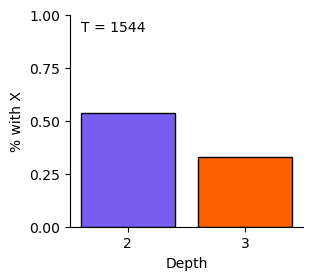

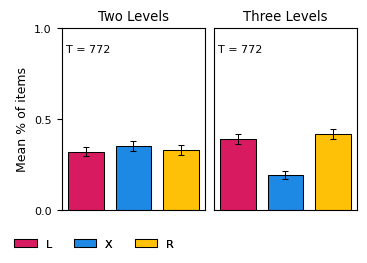

In [8]:
plots.new_category_plot(cleanedTrial, figsize=(3, 2.75), fname='Figures/LXR_by_depth.pdf')
print(round(cleanedTrial[['DEPTH', 'HAS_X']].groupby(['DEPTH']).mean().reset_index(), 4))

plots.generate_summary_LXR_plot(cleanedTrial, 'DEPTH', [2, 3], ['Two Levels', 'Three Levels'], figsize=(3.5, 2.15), fname='Figures/AXB_by_depth')

#### 4. When item presentation order conflicts with item location, category assignments will diverge more from the all-at-once condition than other orders
This holds for the left-shifted condition, but not the right-shifted condition.

In [9]:
left_f, left_m, left_b =  analyses.get_jsds(cleanedTrial, 'L')
right_f, right_m, right_b =  analyses.get_jsds(cleanedTrial, 'R')

table = pd.DataFrame({'': ['Left', 'Right'],
        'Forward': [round(left_f,3), round(right_f,3)],
        'Middle': [round(left_m,3), round(right_m,3)],
        'Backward': [round(left_b,3), round(right_b,3)]})

print(table.to_string(index=False))

latex = table.to_latex(index=False, float_format="{:.3f}".format)
with open('Tables/JSD_table.tex', 'w') as f:
    f.write(latex)

print('LEFT')
print(f'bf:{round(left_b-left_f, 3)}, bm:{round(left_b-left_m, 3)}')

print('RIGHT')
print(f'fm:{round(right_f-right_m, 3)}, fb:{round(right_f - right_b, 3)}')



       Forward  Middle  Backward
 Left    0.125   0.048     0.117
Right    0.076   0.071     0.222
LEFT
bf:-0.008, bm:0.069
RIGHT
fm:0.005, fb:-0.146


In [ ]:
pf = analyses.perm_test2(cleanedTrial, 'L', 'f', 10000)
pm = analyses.perm_test2(cleanedTrial, 'L', 'm', 10000)
pb = analyses.perm_test2(cleanedTrial, 'L', 'f', 10000)
print(pf, pm, pb)

0.0005 0.3276 0.0013


In [16]:
pf, pm, pb = analyses.perm_test2(cleanedTrial, 'R', 10000)
print(pf, pm, pb)

0.0891 0.1208 0.0


In [10]:
pbf, pbm = analyses.perm_test(cleanedTrial, 'L', 100)
print(f'{pbf:.3f}, {pbm:.3f}')

0.690, 0.000


In [11]:
pfb, pfm = analyses.perm_test(cleanedTrial, 'R', 100)
print(f'{pfb:.3f}, {pfm:.3f}')

1.000, 0.370


## Additional Results

### Optimality

In [12]:
print(round(cleanedTrial[(cleanedTrial['LOC'] == 'L')].groupby('ORDER').mean(numeric_only=True)[['PROP_L',  'PROP_X', 'PROP_R']], 3))


print(round(cleanedTrial[(cleanedTrial['LOC'] == 'R')].groupby('ORDER').mean(numeric_only=True)[['PROP_L',  'PROP_X', 'PROP_R']], 3))


       PROP_L  PROP_X  PROP_R
ORDER                        
a       0.617   0.230   0.153
b       0.453   0.312   0.234
f       0.779   0.131   0.091
m       0.648   0.244   0.108
       PROP_L  PROP_X  PROP_R
ORDER                        
a       0.151   0.290   0.559
b       0.092   0.078   0.830
f       0.183   0.365   0.451
m       0.093   0.267   0.640


In [13]:
round(trialDF[['ORDER', 'LOC', 'SCORE']].groupby(['LOC', 'ORDER']).median().reset_index())

,LOC,ORDER,SCORE
0,C,a,2481.0
1,C,b,2478.0
2,C,f,2479.0
3,C,m,2483.0
4,L,a,2519.0
5,L,b,2506.0
6,L,f,2535.0
7,L,m,2516.0
8,R,a,2514.0
9,R,b,2535.0


In [14]:
round(trialDF[['LOC', 'SCORE']].groupby(['LOC']).max())

,SCORE
LOC,
C,2508.0
L,2563.0
R,2563.0


Participants are sensitive to item location

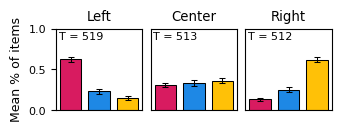

In [21]:
plots.generate_summary_LXR_plot(cleanedTrial, 'LOC', ['L', 'C', 'R'], ['Left', 'Center', 'Right'],  fname='Figures/AXB_by_loc.pdf', figsize=(3.3, 1.15), legend=False)

Participants are sensitive to the specific stimulus set used

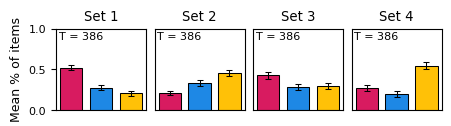

In [22]:
plots.generate_summary_LXR_plot(cleanedTrial, 'STIMULI', [1, 2, 3, 4], ['Set 1', 'Set 2', 'Set 3', 'Set 4'], fname='Figures/AXB_by_set.pdf', figsize=(4.4, 1.15), legend=False)

What's going on at the 3rd level?

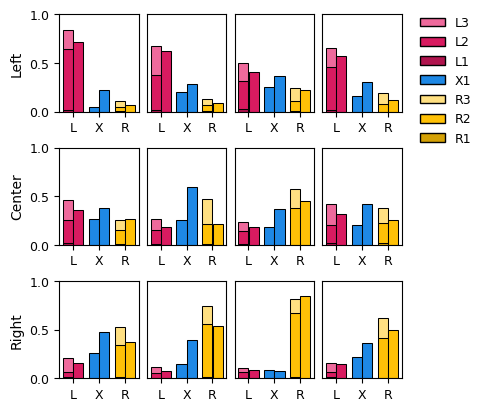

In [17]:
# grouped_df = trialDF[trialDF['DEPTH'] == 3].groupby(['LOC', 'ORDER']).mean(numeric_only=True).reset_index()
# grouped_df

import copy
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
lev2_df = cleanedTrial[cleanedTrial['DEPTH'] == 2]


L_colors = ['#B0144E', '#D81B60', '#EE6A9C']  
R_colors = ['#D4A106', '#FFC107', '#FFE082']

lev3_df = copy.deepcopy(trialDF[trialDF['DEPTH'] == 3])
lev3_df['PROP_L1'] = lev3_df[lev3_df[ITEMS] == 'L1'].count(axis=1)/9
lev3_df['PROP_L2'] = lev3_df[lev3_df[ITEMS] == 'L2'].count(axis=1)/9
lev3_df['PROP_L3'] = lev3_df[lev3_df[ITEMS] == 'L3'].count(axis=1)/9
lev3_df['PROP_X1'] = lev3_df[lev3_df[ITEMS] == 'X1'].count(axis=1)/9
lev3_df['PROP_R1'] = lev3_df[lev3_df[ITEMS] == 'R1'].count(axis=1)/9
lev3_df['PROP_R2'] = lev3_df[lev3_df[ITEMS] == 'R2'].count(axis=1)/9
lev3_df['PROP_R3'] = lev3_df[lev3_df[ITEMS] == 'R3'].count(axis=1)/9

fig, axes = plt.subplots(3, 4, figsize=(4, 4), constrained_layout=True)
grouped_df = lev3_df.groupby(['LOC', 'ORDER']).mean(numeric_only=True).reset_index() 

lev2_df = lev2_df.groupby(['LOC', 'ORDER']).mean(numeric_only=True).reset_index()
orders = ['Forward', 'Middle', 'Backward', 'All at once']
locations = ['Left', 'Center', 'Right', 'Overall']
for i in range(3):
    for j in range(4):
            ax = axes[i, j]
            ax.tick_params(axis='both', which='major', labelsize=9)
            order = orders[j].lower()[0]
            loc = locations[i][0]
            vals = grouped_df[
                (grouped_df['LOC'] == loc) & (grouped_df['ORDER'] == order)
            ][[
                'PROP_L1', 'PROP_L2', 'PROP_L3','PROP_X1','PROP_R1', 'PROP_R2', 'PROP_R3'
            ]].values[0]

            y = lev2_df[(lev2_df['LOC'] == loc) & (lev2_df['ORDER'] == order)][['PROP_L', 'PROP_X', 'PROP_R']].values[0]
            # x positions
            x_labels = ['L', 'X', 'R']
            x_pos = range(len(x_labels))

            # ---- stacked L ----
            ax.bar(x_pos[0]-0.2, vals[0], color=L_colors[0], edgecolor='black', width=0.39, linewidth=0.75)
            ax.bar(x_pos[0]-0.2, vals[1], bottom=vals[0], color=L_colors[1], edgecolor='black', width=0.39, linewidth=0.75)
            ax.bar(x_pos[0]-0.2, vals[2], bottom=vals[0] + vals[1], color=L_colors[2], edgecolor='black', width=0.39, linewidth=0.75)

            ax.bar(x_pos[0]+0.2, y[0], color='#D81B60', edgecolor='black', width=0.39, linewidth=0.75)

            ax.bar(x_pos[1]-0.2, vals[3], color='#1E88E5', edgecolor='black', width=0.39, linewidth=0.75)
            ax.bar(x_pos[1]+0.2, y[1], color='#1E88E5', edgecolor='black', width=0.39, linewidth=0.75)


            ax.bar(x_pos[2]-0.2, vals[4], color=R_colors[0], edgecolor='black', width=0.39, linewidth=0.75)
            ax.bar(x_pos[2]-0.2, vals[5], bottom=vals[4], color=R_colors[1], edgecolor='black', width=0.39, linewidth=0.75)
            ax.bar(x_pos[2]-0.2, vals[6], bottom=vals[4] + vals[5], color=R_colors[2], edgecolor='black', width=0.39, linewidth=0.75)

            ax.bar(x_pos[2]+0.2, y[2], color='#FFC107', edgecolor='black', width=0.39, linewidth=0.75)

            ax.set_xticks(x_pos)
            ax.set_xticklabels(x_labels)
            if j == 0:
                ax.set_ylabel(f'{locations[i]}', fontsize=10)
                ax.set_yticks([0.0, 0.5, 1.0])
            else:
                ax.set_yticks([])
            ax.set_ylim(0, 1)


legend_elements = [
    Patch(facecolor='#EE6A9C', edgecolor='black', label='L3'),
    Patch(facecolor='#D81B60', edgecolor='black', label='L2'),
    Patch(facecolor='#B0144E', edgecolor='black', label='L1'),
    Patch(facecolor='#1E88E5', edgecolor='black', label='X1'),
    Patch(facecolor='#FFE082', edgecolor='black', label='R3'),
    Patch(facecolor='#FFC107', edgecolor='black', label='R2'),
    Patch(facecolor='#D4A106', edgecolor='black', label='R1'),
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=1,
    fontsize=9,
    frameon=False,
    bbox_to_anchor=(1.1, 1)
)

In [18]:
import numpy as np
dfs_by_loc = []
for loc, items in LOCS:
    loc_df = lev3_df[lev3_df['LOC'] == loc]
    items = np.array(items)
    seq_dfs = []
    long_dfs = []
    for lab, first_idx, other_idx in ORDERS:
        first = items[first_idx]
        other = items[other_idx].tolist()
        item_subset = loc_df[loc_df['ORDER'] == lab]
        same_as_first = item_subset[[first] + other].apply(lambda x: x[other] == x[first], axis=1)*1
        same_as_first['PROP_SAME'] = same_as_first[other].sum(axis=1) / 8
        same_as_first['FIRST_IT'] = first
        subseq_df = pd.concat([item_subset[['P_ID', 'STIMULI', 'POOL', 'DEPTH', 'LOC', 'ORDER']], item_subset[first], same_as_first], axis=1)
        subseq_df.rename(columns={first: 'FIRST'}, inplace=True)
        long_seq = subseq_df.melt(id_vars = ['P_ID', 'STIMULI', 'POOL', 'DEPTH', 'LOC', 'ORDER', 'FIRST', 'FIRST_IT'], value_vars=other, var_name='ITEM', value_name='SAME')
        long_seq.rename(columns={first: 'FIRST_CAT'}, inplace=True)
        subseq_df.rename(columns={other[i] : f'OTH_{i+1}' for i in range(len(other))}, inplace=True)
        seq_dfs.append(subseq_df)
        long_dfs.append(long_seq)
    dfs_by_loc.append(pd.concat(seq_dfs))
seq_df_3 = pd.concat(dfs_by_loc).reset_index().drop('index', axis=1)

28.45
Mean: 0.637
Median items: 0.75
Mode: 1.0


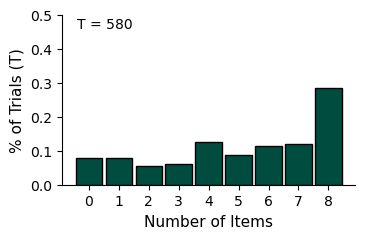

In [19]:
plots.same_as_dist(seq_df_3, figsize=(3.75, 2.5), fname='Figures/seq3.jpg')

mean_prob = seq_df_3['PROP_SAME'].mean()
median_prob = seq_df_3['PROP_SAME'].median()
mode_probs = seq_df_3['PROP_SAME'].mode().values
all_same = seq_df_3[seq_df_3['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df_3.shape[0]
print(f'{round(all_same*100, 2):.2f}')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')